In [1]:
import os, glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
import datetime as dt
import copy

In [129]:
shear_filter = pd.read_csv('/Users/samueleckford/Scripts/Shear Prediction/Quads/shear_master_df_Quad 21_2020_06_29.csv', index_col=0)

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [130]:
shear_filter.head(2)

,DT,GR,RHOB,SP,Wellname,Depth,SPWS,GRWS,NPOWS,CALWS,...,PEFWS,CALI,DTSWS,CAL,DEN,MRES,DTS,DRES,NPO,SRES
0,120.9238,37.3865,2.4670,88.0527,10-1-1,1877.816,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,123.2250,36.9812,2.4605,87.4510,10-1-1,1877.968,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
log_dict = {}
# Lists with different log name abbreviations, can be edited as needed
log_dict['GR_list'] = ['GRWS', 'gr', 'GR']
log_dict['DT_list'] = ['DTWS', 'dt', 'dtws', 'DT']
log_dict['DTS_list'] = ['DTSWS', 'DTS', 'dts', 'dtsws']
log_dict['DRes_list'] = ['DRESWS', 'DRES']
log_dict['Mres_list'] = ['MRESWS', 'MRES']
log_dict['Sres_list'] = ['SRESWS', 'SRES']
log_dict['Rhob_list'] = ['DENWS', 'RHOB', 'RHOBWS', 'RHO', 'RHOWS', 'DEN']
log_dict['Npo_list'] = ['NPOWS', 'NPO']
log_dict['Cal_list'] = ['CALWS', 'CAL', 'CALI']
log_dict['PEF_list'] = ['PEFWS', 'PEF']
log_dict['SP_list'] = ['SPWS', 'SP']

In [132]:
def column_list_merge(df, log_dictionary):
    for i in log_dictionary:
        original_count = df[log_dictionary[i][0]].count()
        for j in log_dictionary[i][1:]:
            try:
                df[log_dictionary[i][0]].fillna(df[j], inplace=True)
                df.drop([j], axis=1, inplace=True)
                print("Number of values added to " +log_dictionary[i][0]+ " column = " + str(abs(original_count - df[log_dictionary[i][0]].count())))
            except:
                print(str(j)+' column does not exist')
                pass

In [133]:
#shear_filter2 = shear_filter.copy()
column_list_merge(shear_filter, log_dict)

gr column does not exist
Number of values added to GRWS column = 7396978
dt column does not exist
dtws column does not exist
Number of values added to DTWS column = 9991271
Number of values added to DTSWS column = 73644
dts column does not exist
dtsws column does not exist
Number of values added to DRESWS column = 19651
Number of values added to MRESWS column = 56868
Number of values added to SRESWS column = 7219
Number of values added to DENWS column = 3615049
RHOBWS column does not exist
RHO column does not exist
RHOWS column does not exist
Number of values added to DENWS column = 3825788
Number of values added to NPOWS column = 12412
Number of values added to CALWS column = 353430
Number of values added to CALWS column = 2889045
Number of values added to PEFWS column = 1711981
Number of values added to SPWS column = 3881750


In [134]:
shear_filter.columns = [col.replace('WS', '') for col in shear_filter.columns]
shear_filter.columns

Index(['Wellname', 'Depth', 'SP', 'GR', 'NPO', 'CAL', 'DRES', 'COND', 'MRES',
       'SRES', 'DT', 'DEN', 'PEF', 'DTS'],
      dtype='object')

In [135]:
well = '13-23a-4'
shear_filter2 = copy.deepcopy(shear_filter)
#shear_filter3 = copy.deepcopy(shear_filter.loc[shear_filter['Wellname']==well])
shear_filter2['DTS'].fillna(450, inplace=True)
#shear_filter.isna().sum()

In [136]:
def rolling_imputer(df, log='DTS', filter_length=100):
    """ Interpolate over smaller distances and filter outside of that.
        Default window length is 100 samples and filtered at >90% of filter_length (above 90 by default). """
    
    ### Flag all the null rows then do a rolling sum to highlight areas with large gaps
    print(str(round(df[log].isna().sum()/len(df), 3)) + " " + log + " proportion of nulls")
    df['test_flag'] = df[log].isna()
    df['test_flag'] = df.groupby('Wellname')['test_flag'].transform(lambda s: s.rolling(filter_length, center=True, min_periods=15).sum())
    ### filter the values that are a large way away from real values
    df.drop(df[df['test_flag'] >(filter_length*0.9)].index, inplace = True)
    #df['test_rolling_mean'] = df[log].rolling(window=25, center=True, win_type='gaussian', min_periods=5).mean(std=1)
    ### Fill nulls with rolling mean values
    df[log].fillna(df.groupby('Wellname')['test_flag'].transform(lambda s: s.rolling(window=250, center=True, min_periods=5, win_type='gaussian').mean(std=1)))
    df.dropna(subset=[log], axis=0, how='any', inplace=True)
    ### Drop extra columns
    df.drop(['test_flag'], axis=1, inplace=True)
    return df

In [137]:
### Initially run just the DTS as this is the target log, then on all others
shear_filter = rolling_imputer(shear_filter)
for i in shear_filter.columns[3:-1]:
    shear_filter = rolling_imputer(shear_filter, log=i)
### SP has a large proportion of nulls so is dropped
shear_filter.drop(['SP'], axis=1, inplace=True)
shear_filter.isna().sum()

0.961 DTS proportion of nulls
0.025 GR proportion of nulls
0.154 NPO proportion of nulls
0.009 CAL proportion of nulls
0.01 DRES proportion of nulls
0.0 COND proportion of nulls
0.047 MRES proportion of nulls
0.095 SRES proportion of nulls
0.001 DT proportion of nulls
0.002 DEN proportion of nulls
0.028 PEF proportion of nulls


Wellname    0
Depth       0
GR          0
NPO         0
CAL         0
DRES        0
COND        0
MRES        0
SRES        0
DT          0
DEN         0
PEF         0
DTS         0
dtype: int64

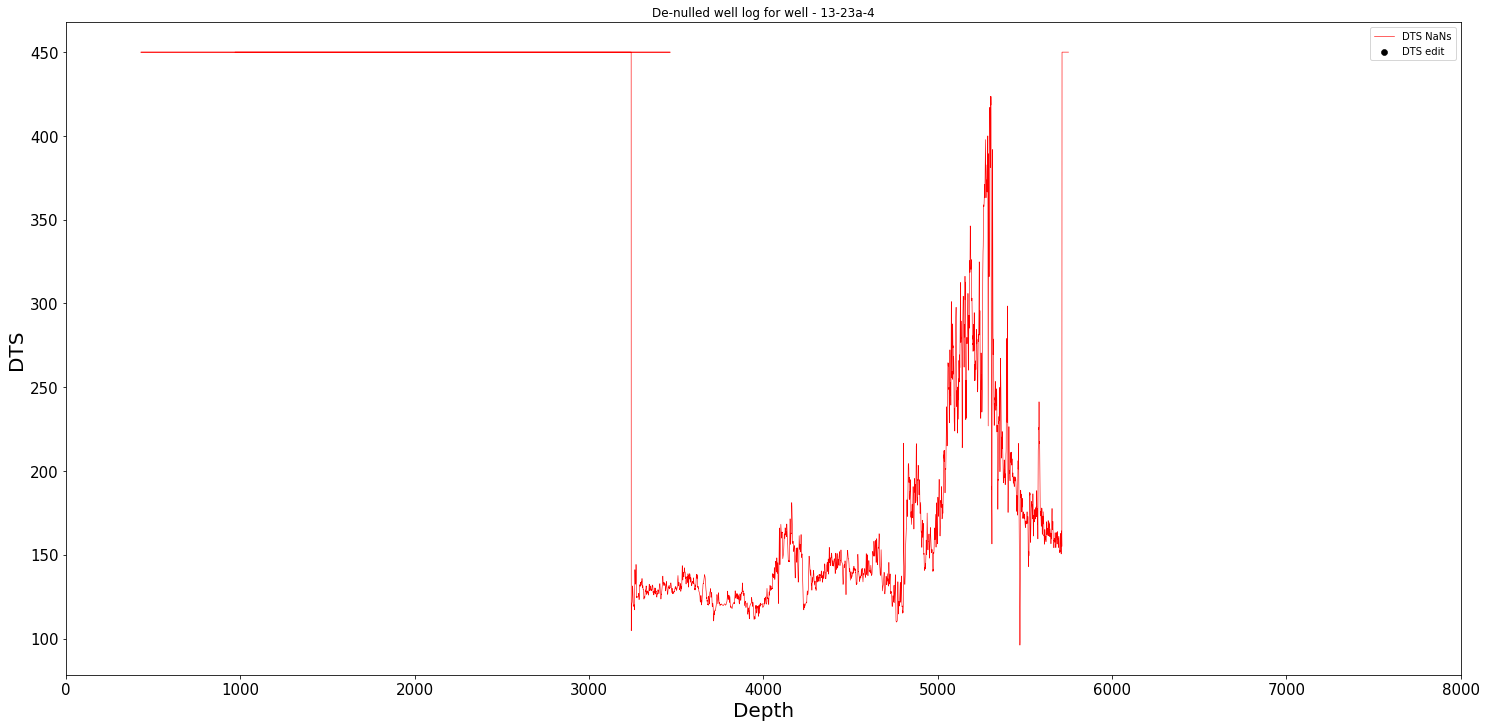

In [138]:
plt.figure(figsize=(25, 12))
well = '13-23a-4'
log = 'DTS'
#plt.scatter(shear_filter3[shear_filter3["Wellname"] == well]["Depth"], shear_filter3[shear_filter3["Wellname"] == well]['test_flag'], s=0.6, color='red', label=log + ' flag ')
plt.plot(shear_filter2[shear_filter2["Wellname"] == well]["Depth"], shear_filter2[shear_filter2["Wellname"] == well][log], linewidth=0.6, color='red', label=log + ' NaNs')
plt.scatter(shear_filter[shear_filter["Wellname"] == well]["Depth"], shear_filter[shear_filter["Wellname"] == well][log], linewidth=0.6, color='black', label=log + ' edit ')
plt.title('De-nulled well log for well - ' + well)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Depth', fontsize = 20)
plt.ylabel(log, fontsize = 20)
plt.xlim(0, 8000)
plt.legend()
plt.show()

In [139]:
shear_filter.to_csv('Quad21_clean.csv')

In [140]:
shear_filter.head()

,Wellname,Depth,GR,NPO,CAL,DRES,COND,MRES,SRES,DT,DEN,PEF,DTS
973542,13-22c-30,8001.5,94.3394,0.2543,11.8982,13.5483,73.8100,27.1916,44.2099,81.6508,2.4825,3.3950,139.1937
973543,13-22c-30,8002.0,85.8017,0.2122,11.9270,13.1327,76.1458,34.8896,49.4245,85.8908,2.5292,2.9600,139.9702
973544,13-22c-30,8002.5,86.0553,0.2235,11.9559,13.1327,76.1458,28.7981,45.2303,90.0853,2.5154,2.8303,144.4100
973545,13-22c-30,8003.0,95.7391,0.2595,11.9707,13.1006,76.3324,23.7700,37.5546,90.8433,2.4427,2.7936,152.0285
973546,13-22c-30,8003.5,109.9114,0.3293,11.9802,13.7400,72.7802,24.7000,33.3261,89.6943,2.4022,2.7781,156.2891


In [141]:
well_list = list(shear_filter.Wellname.unique())
len(well_list)

50

In [151]:
random.seed(42)
test_list = random.sample(well_list, int(len(well_list)*0.3))
train_list = [i for i in well_list if i not in test_list]
#print(test_list)

In [143]:
df_test = shear_filter[shear_filter['Wellname'].isin(test_list)]
df_train = shear_filter[~shear_filter['Wellname'].isin(test_list)]

In [144]:
folder_create = os.path.exists("data")
if folder_create is False:
    os.mkdir("./data")
    os.mkdir("./data/train")
    os.mkdir("./data/test")
folder_create = os.path.exists("./data/train")
if folder_create is False:
    os.mkdir("./data/train")
    os.mkdir("./data/test")

In [145]:
target_feature = ['DTS']
train_feature = ['GR', 'DT', 'DRES', 'MRES', 'SRES', 'NPO', 'DEN', 'Depth', 'COND', 'CAL']

In [146]:
X_train = df_train[train_feature].copy()
X_test = df_test[train_feature].copy()

y_train = df_train[target_feature].copy()
y_test = df_test[target_feature].copy()

In [147]:
X_train.to_csv("./data/train/train_x_" + str(dt.datetime.today().strftime('%Y-%m-%d')) + ".csv")
y_train.to_csv("./data/train/train_y_" + str(dt.datetime.today().strftime('%Y-%m-%d')) + ".csv")
X_test.to_csv("./data/test/test_x_" + str(dt.datetime.today().strftime('%Y-%m-%d')) + ".csv")
y_test.to_csv("./data/test/test_y_" + str(dt.datetime.today().strftime('%Y-%m-%d')) + ".csv")